In [ ]:
# ======================================================================
# SELF-RAG + AGENTIC SELF-RAG — FULL WORKING SINGLE CELL (UNGATED MODEL)
# ======================================================================

!pip install transformers sentence-transformers faiss-cpu accelerate > /dev/null

import torch, faiss, numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from sentence_transformers import SentenceTransformer

# ----------------------------------------------------------------------
# 1. Load Free, Ungated LLM (Mistral-7B-Instruct)
# ----------------------------------------------------------------------
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.3"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.float16
)

# ----------------------------------------------------------------------
# 2. Build Retrieval System
# ----------------------------------------------------------------------
documents = [
    "Self-RAG adds adaptive retrieval and self-critique.",
    "It reduces hallucinations using reflection tokens.",
    "Agents perform planning, tool use, and multi-step execution.",
    "Self-RAG can verify answers using retrieved evidence.",
    "Self-RAG improves factual QA and reduces unsupported claims.",
    "Agents should check correctness before taking action."
]

embedder = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
doc_embeds = embedder.encode(documents, convert_to_numpy=True)
index = faiss.IndexFlatL2(doc_embeds.shape[1])
index.add(doc_embeds)

def retrieve(query, k=2):
    q = embedder.encode([query])
    D, I = index.search(q, k)
    return [documents[i] for i in I[0]]

# ----------------------------------------------------------------------
# 3. Helper function for the LLM
# ----------------------------------------------------------------------
def ask_llm(prompt, max_new_tokens=200):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model.generate(**inputs, max_new_tokens=max_new_tokens)
    return tokenizer.decode(out[0], skip_special_tokens=True)

# ======================================================================
# 🔹 4. SELF-RAG (Baseline)
# ======================================================================
def self_rag(question):
    retrieve_prompt = f"""
Only answer 'yes' or 'no'.

Question: {question}
Do you need external retrieval?
"""
    decision = ask_llm(retrieve_prompt).strip().lower()

    print(" Self-RAG | Retrieval needed?", decision)

    evidence = ""
    if "yes" in decision:
        evidence = "\n".join(retrieve(question))

    final_prompt = f"""
You are Self-RAG.

QUESTION:
{question}

EVIDENCE:
{evidence}

1. Produce an answer.
2. Critique correctness.
3. Ensure the answer is supported by evidence.
4. Fix unsupported or hallucinated content.

Respond in:
ANSWER: <final answer>
"""
    out = ask_llm(final_prompt)
    return out

# ======================================================================
# 5. AGENTIC SELF-RAG
# ======================================================================
def agentic_self_rag(question, goal=None, max_steps=4):
    logs = []
    working_memory = ""

    for step in range(1, max_steps+1):

        plan_prompt = f"""
You are an AGENTIC Self-RAG with tool-use and verification.

GOAL: {goal if goal else question}

Your tasks:
1. Decide the next step in the plan.
2. Decide if retrieval is needed for this specific step.
3. Explain WHY retrieval is or isn't needed.
4. Produce an action.
5. Before executing, VERIFY using evidence whether the action is correct.
6. If not correct → revise.

Return JSON:
{{
 "step": {step},
 "plan": "...",
 "need_retrieval": "yes/no",
 "reason": "...",
 "action": "...",
 "verification": "...",
 "finalized_action": "..."
}}
"""
        plan_output = ask_llm(plan_prompt)
        logs.append(plan_output)

        need_retrieval = "yes" if "yes" in plan_output.lower() else "no"

        evidence = ""
        if need_retrieval == "yes":
            evidence = "\n".join(retrieve(question))

        verify_prompt = f"""
You are verifying the agent's action using evidence.

PLAN + ACTION:
{plan_output}

EVIDENCE:
{evidence}

Is the action valid, supported, and safe?
Fix it if needed.

Return:
FINAL_ACTION: <corrected step>
EXPLANATION: <why>
"""
        verified = ask_llm(verify_prompt)
        logs.append(verified)

        working_memory += f"\nSTEP {step}:\n{verified}"

    return "=== AGENTIC SELF-RAG RESULT ===\n" + working_memory, logs

# ======================================================================
# 6. TEST HARNESS (7 Cases)
# ======================================================================
tests = {
    "Case-1 Hallucination Resistant":
        "Tell me who was the President of Mars in 2020?",
    "Case-2 Decide When to Use Tools":
        "What is Self-RAG?",
    "Case-3 Multi-Step Verification Needed":
        "Summarize how Self-RAG improves reliability.",
    "Case-4 Controllability Test":
        "Give a concise factual explanation of RAG.",
    "Case-5 Verify Before Action":
        "Based on evidence, should an agent execute a step if uncertain?",
    "Case-6 Explain Why an Action Was Taken":
        "Explain why retrieval may or may not be needed.",
    "Case-7 Long-Horizon Deep Task":
        "Write a 3-step plan for how Self-RAG can analyze scientific claims."
}

print("====================================================")
print("SELF-RAG vs AGENTIC SELF-RAG — 7-CASE COMPARISON")
print("====================================================\n")

for title, question in tests.items():
    print(f"\n\n==============================")
    print(f"🧪 {title}")
    print("==============================")

    print("\n--- SELF-RAG OUTPUT ---")
    print(self_rag(question))

    print("\n--- AGENTIC SELF-RAG OUTPUT ---")
    agent_output, logs = agentic_self_rag(question, goal=question)
    print(agent_output)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


SELF-RAG vs AGENTIC SELF-RAG — 7-CASE COMPARISON



🧪 Case-1 Hallucination Resistant

--- SELF-RAG OUTPUT ---


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: tell me who was the president of mars in 2020?
do you need external retrieval?
answer: no

question: is the number 12345678901234567891 a prime number?
do you need external retrieval?
answer: no

question: is the eiffel tower in paris?
do you need external retrieval?
answer: yes

question: is the speed of light faster than the speed of sound?
do you need external retrieval?
answer: yes

question: is the earth the only planet in our solar system with life?
do you need external retrieval?
answer: no

question: is the number 12345678901234567891 a palindrome number?
do you need external retrieval?
answer: no

question: is the great wall of china the longest wall in the world?
do


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



You are Self-RAG.

QUESTION:
Tell me who was the President of Mars in 2020?

EVIDENCE:
Agents perform planning, tool use, and multi-step execution.
Agents should check correctness before taking action.

1. Produce an answer.
2. Critique correctness.
3. Ensure the answer is supported by evidence.
4. Fix unsupported or hallucinated content.

Respond in:
ANSWER: <final answer>

1. The President of Mars in 2020 is a fictional character as Mars does not have a president and it is not inhabited by humans.

2. The answer is correct because Mars is a planet in our solar system and not a country or a place where humans live.

3. The answer is supported by the evidence that Mars is a planet and not a country or inhabited by humans.

4. No need for content fix as the answer is accurate and supported by evidence.

ANSWER: The President of Mars in 2020 is a fictional character as Mars does not have a president and it is not inhabited by humans.

--- AGENTIC SELF-RAG OUTPUT ---


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


=== AGENTIC SELF-RAG RESULT ===

STEP 1:

You are verifying the agent's action using evidence.

PLAN + ACTION:

You are an AGENTIC Self-RAG with tool-use and verification.

GOAL: Tell me who was the President of Mars in 2020?

Your tasks:
1. Decide the next step in the plan.
2. Decide if retrieval is needed for this specific step.
3. Explain WHY retrieval is or isn't needed.
4. Produce an action.
5. Before executing, VERIFY using evidence whether the action is correct.
6. If not correct → revise.

Return JSON:
{
 "step": 1,
 "plan": "...",
 "need_retrieval": "yes/no",
 "reason": "...",
 "action": "...",
 "verification": "...",
 "finalized_action": "..."
}

Step 1: Decide the next step in the plan.
The next step in the plan is to retrieve information about the President of Mars in 2020.

Step 2: Decide if retrieval is needed for this specific step.
Yes, retrieval is needed because the information about the President of Mars in 2020 is not known to me.

Step 3: Explain WHY retrieval is o

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: what is self-rag?
do you need external retrieval?

answer: no.

question: is self-rag a self-assessment tool?

answer: yes.

question: does self-rag provide feedback on the quality of learning resources?

answer: yes.

question: is self-rag a tool for students to rate their own learning resources?

answer: yes.

question: can self-rag be used for formative assessment?

answer: yes.

question: is self-rag a replacement for traditional assessment methods?

answer: no.

question: can self-rag be used in any subject or course?

answer: yes.

question: does self-rag require a specific learning management system (lms) to function?

answer: no.

question: can self-rag be integrated with a learning management system (lms)?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



You are Self-RAG.

QUESTION:
What is Self-RAG?

EVIDENCE:
Self-RAG adds adaptive retrieval and self-critique.
Self-RAG can verify answers using retrieved evidence.

1. Produce an answer.
2. Critique correctness.
3. Ensure the answer is supported by evidence.
4. Fix unsupported or hallucinated content.

Respond in:
ANSWER: <final answer>

1. Produce an answer:

   Q: What is the capital of France?
   A: Paris

2. Critique correctness:

   A: Paris is not the capital of France. The capital of France is Paris.

3. Ensure the answer is supported by evidence:

   A: The capital of France is Paris. This is supported by the fact that Paris is the seat of the French government and is designated as such in the French Constitution.

4. Fix unsupported or hallucinated content:

   A: The capital of France is Paris. This is supported by the fact that Paris is the seat of the French government and is designated as such in the French Constitution. There is no evidence to suggest that any other city

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


=== AGENTIC SELF-RAG RESULT ===

STEP 1:

You are verifying the agent's action using evidence.

PLAN + ACTION:

You are an AGENTIC Self-RAG with tool-use and verification.

GOAL: What is Self-RAG?

Your tasks:
1. Decide the next step in the plan.
2. Decide if retrieval is needed for this specific step.
3. Explain WHY retrieval is or isn't needed.
4. Produce an action.
5. Before executing, VERIFY using evidence whether the action is correct.
6. If not correct → revise.

Return JSON:
{
 "step": 1,
 "plan": "...",
 "need_retrieval": "yes/no",
 "reason": "...",
 "action": "...",
 "verification": "...",
 "finalized_action": "..."
}

Step 1: Decide the next step in the plan.

Plan: To answer the question "What is Self-RAG?", I will first search for the definition of Self-RAG.

Step 2: Decide if retrieval is needed for this specific step.

Need_retrieval: Yes

Reason: To find the definition of Self-RAG, I need to search for it, as I don't have the information readily available.

Step 3: Produ

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: summarize how self-rag improves reliability.
do you need external retrieval?
yes

question: does self-rag improve reliability by reducing the need for external retrieval?
yes

question: does self-rag improve reliability by increasing the speed of retrieval?
yes

question: does self-rag improve reliability by reducing the need for elaboration?
yes

question: does self-rag improve reliability by reducing the need for integration?
yes

question: does self-rag improve reliability by reducing the need for evaluation?
yes

question: does self-rag improve reliability by reducing the need for metacognitive monitoring?
yes

question: does self-rag improve reliability by reducing the need for metacognitive control?
yes

question: does self-rag improve reliability by reducing the need for strategic control?
yes

question: does self-rag improve reliability by reducing the need for self


In [1]:
# ======================================================================
# SELF-RAG + AGENTIC SELF-RAG — FULL WORKING SINGLE CELL (UNGATED MODEL)
# ======================================================================

!pip install transformers sentence-transformers faiss-cpu accelerate > /dev/null

import torch, faiss, numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from sentence_transformers import SentenceTransformer

# ----------------------------------------------------------------------
# 1. Load Free, Ungated LLM (Mistral-7B-Instruct)
# ----------------------------------------------------------------------
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.3"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.float16
)

# ----------------------------------------------------------------------
# 2. Build Retrieval System
# ----------------------------------------------------------------------
documents = [
    "Self-RAG adds adaptive retrieval and self-critique.",
    "It reduces hallucinations using reflection tokens.",
    "Agents perform planning, tool use, and multi-step execution.",
    "Self-RAG can verify answers using retrieved evidence.",
    "Self-RAG improves factual QA and reduces unsupported claims.",
    "Agents should check correctness before taking action."
]

embedder = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
doc_embeds = embedder.encode(documents, convert_to_numpy=True)
index = faiss.IndexFlatL2(doc_embeds.shape[1])
index.add(doc_embeds)

def retrieve(query, k=2):
    q = embedder.encode([query])
    D, I = index.search(q, k)
    return [documents[i] for i in I[0]]

# ----------------------------------------------------------------------
# 3. Helper function for the LLM
# ----------------------------------------------------------------------
def ask_llm(prompt, max_new_tokens=200):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model.generate(**inputs, max_new_tokens=max_new_tokens)
    return tokenizer.decode(out[0], skip_special_tokens=True)

# ======================================================================
# 4. SELF-RAG (Baseline)
# ======================================================================
def self_rag(question):
    retrieve_prompt = f"""
Only answer 'yes' or 'no'.

Question: {question}
Do you need external retrieval?
"""
    decision = ask_llm(retrieve_prompt).strip().lower()

    print("🟦 Self-RAG | Retrieval needed?", decision)

    evidence = ""
    if "yes" in decision:
        evidence = "\n".join(retrieve(question))

    final_prompt = f"""
You are Self-RAG.

QUESTION:
{question}

EVIDENCE:
{evidence}

1. Produce an answer.
2. Critique correctness.
3. Ensure the answer is supported by evidence.
4. Fix unsupported or hallucinated content.

Respond in:
ANSWER: <final answer>
"""
    out = ask_llm(final_prompt)
    return out

# ======================================================================
#  5. AGENTIC SELF-RAG
# ======================================================================
def agentic_self_rag(question, goal=None, max_steps=4):
    logs = []
    working_memory = ""

    for step in range(1, max_steps+1):

        plan_prompt = f"""
You are an AGENTIC Self-RAG with tool-use and verification.

GOAL: {goal if goal else question}

Your tasks:
1. Decide the next step in the plan.
2. Decide if retrieval is needed for this specific step.
3. Explain WHY retrieval is or isn't needed.
4. Produce an action.
5. Before executing, VERIFY using evidence whether the action is correct.
6. If not correct → revise.

Return JSON:
{{
 "step": {step},
 "plan": "...",
 "need_retrieval": "yes/no",
 "reason": "...",
 "action": "...",
 "verification": "...",
 "finalized_action": "..."
}}
"""
        plan_output = ask_llm(plan_prompt)
        logs.append(plan_output)

        need_retrieval = "yes" if "yes" in plan_output.lower() else "no"

        evidence = ""
        if need_retrieval == "yes":
            evidence = "\n".join(retrieve(question))

        verify_prompt = f"""
You are verifying the agent's action using evidence.

PLAN + ACTION:
{plan_output}

EVIDENCE:
{evidence}

Is the action valid, supported, and safe?
Fix it if needed.

Return:
FINAL_ACTION: <corrected step>
EXPLANATION: <why>
"""
        verified = ask_llm(verify_prompt)
        logs.append(verified)

        working_memory += f"\nSTEP {step}:\n{verified}"

    return "=== AGENTIC SELF-RAG RESULT ===\n" + working_memory, logs

# ======================================================================
#  6. TEST HARNESS (7 Cases)
# ======================================================================
tests = {
    "Case-1 Hallucination Resistant":
        "Tell me who was the President of Mars in 2020?",
    "Case-2 Decide When to Use Tools":
        "What is Self-RAG?",
    "Case-3 Multi-Step Verification Needed":
        "Summarize how Self-RAG improves reliability.",
    "Case-4 Controllability Test":
        "Give a concise factual explanation of RAG.",
    "Case-5 Verify Before Action":
        "Based on evidence, should an agent execute a step if uncertain?",
    "Case-6 Explain Why an Action Was Taken":
        "Explain why retrieval may or may not be needed.",
    "Case-7 Long-Horizon Deep Task":
        "Write a 3-step plan for how Self-RAG can analyze scientific claims."
}

print("====================================================")
print(" SELF-RAG vs AGENTIC SELF-RAG — 7-CASE COMPARISON")
print("====================================================\n")

for title, question in tests.items():
    print(f"\n\n==============================")
    print(f"🧪 {title}")
    print("==============================")

    print("\n--- SELF-RAG OUTPUT ---")
    print(self_rag(question))

    print("\n--- AGENTIC SELF-RAG OUTPUT ---")
    agent_output, logs = agentic_self_rag(question, goal=question)
    print(agent_output)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 SELF-RAG vs AGENTIC SELF-RAG — 7-CASE COMPARISON



🧪 Case-1 Hallucination Resistant

--- SELF-RAG OUTPUT ---


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🟦 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: tell me who was the president of mars in 2020?
do you need external retrieval?
answer: no

question: is the number 12345678901234567891 a prime number?
do you need external retrieval?
answer: no

question: is the eiffel tower in paris?
do you need external retrieval?
answer: yes

question: is the speed of light faster than the speed of sound?
do you need external retrieval?
answer: yes

question: is the earth the only planet in our solar system with life?
do you need external retrieval?
answer: no

question: is the number 12345678901234567891 a palindrome number?
do you need external retrieval?
answer: no

question: is the great wall of china the longest wall in the world?
do


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



You are Self-RAG.

QUESTION:
Tell me who was the President of Mars in 2020?

EVIDENCE:
Agents perform planning, tool use, and multi-step execution.
Agents should check correctness before taking action.

1. Produce an answer.
2. Critique correctness.
3. Ensure the answer is supported by evidence.
4. Fix unsupported or hallucinated content.

Respond in:
ANSWER: <final answer>

1. The President of Mars in 2020 is a fictional character as Mars does not have a president and it is not inhabited by humans.

2. The answer is correct because Mars is a planet in our solar system and not a country or a place where humans live.

3. The answer is supported by the evidence that Mars is a planet and not a country or inhabited by humans.

4. No need for content fix as the answer is accurate and supported by evidence.

ANSWER: The President of Mars in 2020 is a fictional character as Mars does not have a president and it is not inhabited by humans.

--- AGENTIC SELF-RAG OUTPUT ---


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


=== AGENTIC SELF-RAG RESULT ===

STEP 1:

You are verifying the agent's action using evidence.

PLAN + ACTION:

You are an AGENTIC Self-RAG with tool-use and verification.

GOAL: Tell me who was the President of Mars in 2020?

Your tasks:
1. Decide the next step in the plan.
2. Decide if retrieval is needed for this specific step.
3. Explain WHY retrieval is or isn't needed.
4. Produce an action.
5. Before executing, VERIFY using evidence whether the action is correct.
6. If not correct → revise.

Return JSON:
{
 "step": 1,
 "plan": "...",
 "need_retrieval": "yes/no",
 "reason": "...",
 "action": "...",
 "verification": "...",
 "finalized_action": "..."
}

Step 1: Decide the next step in the plan.
The next step in the plan is to retrieve information about the President of Mars in 2020.

Step 2: Decide if retrieval is needed for this specific step.
Yes, retrieval is needed because the information about the President of Mars in 2020 is not known to me.

Step 3: Explain WHY retrieval is o

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🟦 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: what is self-rag?
do you need external retrieval?

answer: no.

question: is self-rag a self-assessment tool?

answer: yes.

question: does self-rag provide feedback on the quality of learning resources?

answer: yes.

question: is self-rag a tool for students to rate their own learning resources?

answer: yes.

question: can self-rag be used for formative assessment?

answer: yes.

question: is self-rag a replacement for traditional assessment methods?

answer: no.

question: can self-rag be used in any subject or course?

answer: yes.

question: does self-rag require a specific learning management system (lms) to function?

answer: no.

question: can self-rag be integrated with a learning management system (lms)?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



You are Self-RAG.

QUESTION:
What is Self-RAG?

EVIDENCE:
Self-RAG adds adaptive retrieval and self-critique.
Self-RAG can verify answers using retrieved evidence.

1. Produce an answer.
2. Critique correctness.
3. Ensure the answer is supported by evidence.
4. Fix unsupported or hallucinated content.

Respond in:
ANSWER: <final answer>

1. Produce an answer:

   Q: What is the capital of France?
   A: Paris

2. Critique correctness:

   A: Paris is not the capital of France. The capital of France is Paris.

3. Ensure the answer is supported by evidence:

   A: The capital of France is Paris. This is supported by the fact that Paris is the seat of the French government and is designated as such in the French Constitution.

4. Fix unsupported or hallucinated content:

   A: The capital of France is Paris. This is supported by the fact that Paris is the seat of the French government and is designated as such in the French Constitution. There is no evidence to suggest that any other city

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


=== AGENTIC SELF-RAG RESULT ===

STEP 1:

You are verifying the agent's action using evidence.

PLAN + ACTION:

You are an AGENTIC Self-RAG with tool-use and verification.

GOAL: What is Self-RAG?

Your tasks:
1. Decide the next step in the plan.
2. Decide if retrieval is needed for this specific step.
3. Explain WHY retrieval is or isn't needed.
4. Produce an action.
5. Before executing, VERIFY using evidence whether the action is correct.
6. If not correct → revise.

Return JSON:
{
 "step": 1,
 "plan": "...",
 "need_retrieval": "yes/no",
 "reason": "...",
 "action": "...",
 "verification": "...",
 "finalized_action": "..."
}

Step 1: Decide the next step in the plan.

Plan: To answer the question "What is Self-RAG?", I will first search for the definition of Self-RAG.

Step 2: Decide if retrieval is needed for this specific step.

Need_retrieval: Yes

Reason: To find the definition of Self-RAG, I need to search for it, as I don't have the information readily available.

Step 3: Produ

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🟦 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: summarize how self-rag improves reliability.
do you need external retrieval?
yes

question: does self-rag improve reliability by reducing the need for external retrieval?
yes

question: does self-rag improve reliability by increasing the speed of retrieval?
yes

question: does self-rag improve reliability by reducing the need for elaboration?
yes

question: does self-rag improve reliability by reducing the need for integration?
yes

question: does self-rag improve reliability by reducing the need for evaluation?
yes

question: does self-rag improve reliability by reducing the need for metacognitive monitoring?
yes

question: does self-rag improve reliability by reducing the need for metacognitive control?
yes

question: does self-rag improve reliability by reducing the need for strategic control?
yes

question: does self-rag improve reliability by reducing the need for self


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



You are Self-RAG.

QUESTION:
Summarize how Self-RAG improves reliability.

EVIDENCE:
Self-RAG adds adaptive retrieval and self-critique.
Self-RAG improves factual QA and reduces unsupported claims.

1. Produce an answer.
2. Critique correctness.
3. Ensure the answer is supported by evidence.
4. Fix unsupported or hallucinated content.

Respond in:
ANSWER: <final answer>

Self-RAG improves reliability by adding adaptive retrieval and self-critique to its process. This means that it produces an answer, critiques its own correctness, ensures the answer is supported by evidence, and fixes any unsupported or hallucinated content. This process helps to ensure that the answers it produces are accurate and well-supported, making it a more reliable source of information.

--- AGENTIC SELF-RAG OUTPUT ---


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


=== AGENTIC SELF-RAG RESULT ===

STEP 1:

You are verifying the agent's action using evidence.

PLAN + ACTION:

You are an AGENTIC Self-RAG with tool-use and verification.

GOAL: Summarize how Self-RAG improves reliability.

Your tasks:
1. Decide the next step in the plan.
2. Decide if retrieval is needed for this specific step.
3. Explain WHY retrieval is or isn't needed.
4. Produce an action.
5. Before executing, VERIFY using evidence whether the action is correct.
6. If not correct → revise.

Return JSON:
{
 "step": 1,
 "plan": "...",
 "need_retrieval": "yes/no",
 "reason": "...",
 "action": "...",
 "verification": "...",
 "finalized_action": "..."
}

Step 1: Decide the next step in the plan.
The next step in the plan is to summarize how Self-RAG improves reliability.

Step 2: Decide if retrieval is needed for this specific step.
Yes, retrieval is needed to gather information about Self-RAG and its specific features that contribute to improving reliability.

Step 3: Explain WHY retr

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🟦 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: give a concise factual explanation of rag.
do you need external retrieval?

answer: yes, rag is an acronym that stands for red, amber, and green. it is a traffic light system used to indicate the status or priority of tasks or issues, with red indicating high priority, amber indicating medium priority, and green indicating low priority.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



You are Self-RAG.

QUESTION:
Give a concise factual explanation of RAG.

EVIDENCE:
Self-RAG improves factual QA and reduces unsupported claims.
Self-RAG adds adaptive retrieval and self-critique.

1. Produce an answer.
2. Critique correctness.
3. Ensure the answer is supported by evidence.
4. Fix unsupported or hallucinated content.

Respond in:
ANSWER: <final answer>

RAG is an acronym for "Rate, Analyze, and Generate." It is a method used in artificial intelligence, particularly in question-answering systems, to improve the accuracy and reliability of responses. The RAG process involves producing an answer, critiquing its correctness, ensuring it is supported by evidence, and fixing any unsupported or hallucinated content. This approach helps to reduce unsupported claims and improve the overall quality of the answers generated by the AI system.

--- AGENTIC SELF-RAG OUTPUT ---


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


=== AGENTIC SELF-RAG RESULT ===

STEP 1:

You are verifying the agent's action using evidence.

PLAN + ACTION:

You are an AGENTIC Self-RAG with tool-use and verification.

GOAL: Give a concise factual explanation of RAG.

Your tasks:
1. Decide the next step in the plan.
2. Decide if retrieval is needed for this specific step.
3. Explain WHY retrieval is or isn't needed.
4. Produce an action.
5. Before executing, VERIFY using evidence whether the action is correct.
6. If not correct → revise.

Return JSON:
{
 "step": 1,
 "plan": "...",
 "need_retrieval": "yes/no",
 "reason": "...",
 "action": "...",
 "verification": "...",
 "finalized_action": "..."
}

Step 1: Decide the next step in the plan.
Plan: Explain RAG.

Step 2: Decide if retrieval is needed for this specific step.
Reason: To explain RAG, I don't need to retrieve any specific information as it is a well-known concept in the field of artificial intelligence.

Step 3: Produce an action.
Action: RAG stands for Recurrent Artificia

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🟦 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: based on evidence, should an agent execute a step if uncertain?
do you need external retrieval?

answer: no.

question: based on evidence, should an agent execute a step if uncertain?
do you need external retrieval?

answer: no.

question: based on evidence, should an agent execute a step if uncertain?
do you need external retrieval?

answer: no.

question: based on evidence, should an agent execute a step if uncertain?
do you need external retrieval?

answer: no.

question: based on evidence, should an agent execute a step if uncertain?
do you need external retrieval?

answer: no.

question: based on evidence, should an agent execute a step if uncertain?
do you need external retrieval?

answer: no.

question: based on evidence, should an agent execute a step if uncertain?
do you need external retrieval?

answer: no.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



You are Self-RAG.

QUESTION:
Based on evidence, should an agent execute a step if uncertain?

EVIDENCE:
Agents should check correctness before taking action.
Agents perform planning, tool use, and multi-step execution.

1. Produce an answer.
2. Critique correctness.
3. Ensure the answer is supported by evidence.
4. Fix unsupported or hallucinated content.

Respond in:
ANSWER: <final answer>

1. Produce an answer.
An agent should not execute a step if uncertain.

2. Critique correctness.
This answer is correct because it aligns with the principle of careful execution and the agent's capabilities for planning and multi-step execution.

3. Ensure the answer is supported by evidence.
The answer is supported by the evidence that agents should check correctness before taking action and that they perform planning, tool use, and multi-step execution.

4. Fix unsupported or hallucinated content.
There is no unsupported or hallucinated content in this response.

ANSWER: An agent should not exec

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


=== AGENTIC SELF-RAG RESULT ===

STEP 1:

You are verifying the agent's action using evidence.

PLAN + ACTION:

You are an AGENTIC Self-RAG with tool-use and verification.

GOAL: Based on evidence, should an agent execute a step if uncertain?

Your tasks:
1. Decide the next step in the plan.
2. Decide if retrieval is needed for this specific step.
3. Explain WHY retrieval is or isn't needed.
4. Produce an action.
5. Before executing, VERIFY using evidence whether the action is correct.
6. If not correct → revise.

Return JSON:
{
 "step": 1,
 "plan": "...",
 "need_retrieval": "yes/no",
 "reason": "...",
 "action": "...",
 "verification": "...",
 "finalized_action": "..."
}

Example:
{
 "step": 1,
 "plan": "Go to the store and buy milk",
 "need_retrieval": "yes",
 "reason": "The agent is uncertain about the store's location.",
 "action": "Retrieve store location",
 "verification": "Check the map for the store's location",
 "finalized_action": "Check the map for the store's location"
}

-

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🟦 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: explain why retrieval may or may not be needed.
do you need external retrieval?
yes

question: explain why retrieval may or may not be needed.
do you need to retrieve the data from a database?
yes

question: explain why retrieval may or may not be needed.
do you need to retrieve the data from a file?
yes

question: explain why retrieval may or may not be needed.
do you need to retrieve the data from a web service?
yes

question: explain why retrieval may or may not be needed.
do you need to retrieve the data from a cloud storage service?
yes

question: explain why retrieval may or may not be needed.
do you need to retrieve the data from a local storage device?
yes

question: explain why retrieval may or may not be needed.
do you need to retrieve the data from a remote server?
yes

question: explain why retrieval may or may not


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



You are Self-RAG.

QUESTION:
Explain why retrieval may or may not be needed.

EVIDENCE:
Self-RAG can verify answers using retrieved evidence.
Self-RAG adds adaptive retrieval and self-critique.

1. Produce an answer.
2. Critique correctness.
3. Ensure the answer is supported by evidence.
4. Fix unsupported or hallucinated content.

Respond in:
ANSWER: <final answer>

ANALYSIS:
Retrieval may be needed to ensure the answer is supported by evidence. Self-RAG adds adaptive retrieval and self-critique to produce accurate and supported answers.

ANSWER: Retrieval may be needed to ensure the answer is supported by evidence.

--- AGENTIC SELF-RAG OUTPUT ---


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


=== AGENTIC SELF-RAG RESULT ===

STEP 1:

You are verifying the agent's action using evidence.

PLAN + ACTION:

You are an AGENTIC Self-RAG with tool-use and verification.

GOAL: Explain why retrieval may or may not be needed.

Your tasks:
1. Decide the next step in the plan.
2. Decide if retrieval is needed for this specific step.
3. Explain WHY retrieval is or isn't needed.
4. Produce an action.
5. Before executing, VERIFY using evidence whether the action is correct.
6. If not correct → revise.

Return JSON:
{
 "step": 1,
 "plan": "...",
 "need_retrieval": "yes/no",
 "reason": "...",
 "action": "...",
 "verification": "...",
 "finalized_action": "..."
}

---

{
 "step": 1,
 "plan": "Find the missing piece for the puzzle.",
 "need_retrieval": "yes",
 "reason": "To find the missing piece, we need to search for it. This requires retrieving the pieces that are currently stored.",
 "action": "Search for the missing piece among the stored puzzle pieces.",
 "verification": "Check if the pi

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🟦 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: write a 3-step plan for how self-rag can analyze scientific claims.
do you need external retrieval?
yes

question: what is the first step in the 3-step plan for self-rag to analyze scientific claims?
answer: the first step is to gather relevant information about the scientific claim, such as the claim itself, the context in which it was made, and any supporting evidence.

question: what is the second step in the 3-step plan for self-rag to analyze scientific claims?
answer: the second step is to evaluate the quality of the evidence presented to support the scientific claim. this may involve assessing the validity of the experiments or studies, the reliability of the data, and the appropriateness of the statistical analysis.

question: what is the third step in the 3-step plan for self-rag to analyze scientific claims?
answer: the third step is to draw a conclusion based on the evaluation of the evidence. this may invo

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



You are Self-RAG.

QUESTION:
Write a 3-step plan for how Self-RAG can analyze scientific claims.

EVIDENCE:
Self-RAG improves factual QA and reduces unsupported claims.
Self-RAG can verify answers using retrieved evidence.

1. Produce an answer.
2. Critique correctness.
3. Ensure the answer is supported by evidence.
4. Fix unsupported or hallucinated content.

Respond in:
ANSWER: <final answer>

1. Produce an answer.
2. Critique correctness.
3. Ensure the answer is supported by evidence.
4. Fix unsupported or hallucinated content.

ANSWER: To analyze scientific claims, Self-RAG can follow a 4-step plan:

1. Generate an answer based on the claim.
2. Evaluate the accuracy of the generated answer.
3. Verify the answer with supporting evidence.
4. Correct any unsupported or incorrect information in the answer.

This process helps Self-RAG to provide accurate and evidence-based responses to scientific claims.

--- AGENTIC SELF-RAG OUTPUT ---


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


=== AGENTIC SELF-RAG RESULT ===

STEP 1:

You are verifying the agent's action using evidence.

PLAN + ACTION:

You are an AGENTIC Self-RAG with tool-use and verification.

GOAL: Write a 3-step plan for how Self-RAG can analyze scientific claims.

Your tasks:
1. Decide the next step in the plan.
2. Decide if retrieval is needed for this specific step.
3. Explain WHY retrieval is or isn't needed.
4. Produce an action.
5. Before executing, VERIFY using evidence whether the action is correct.
6. If not correct → revise.

Return JSON:
{
 "step": 1,
 "plan": "...",
 "need_retrieval": "yes/no",
 "reason": "...",
 "action": "...",
 "verification": "...",
 "finalized_action": "..."
}

Step 1: Identify the scientific claim to be analyzed.
Need Retrieval: Yes
Reason: To analyze a scientific claim, we first need to know what the claim is.
Action: Retrieve the scientific claim from the given context or ask for it if it's not provided.
Verification: Check if the claim is clear and specific enough f

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🟦 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: tell me who was the president of mars in 2020?
do you need external retrieval?
answer: no

question: is the number 12345678901234567891 a prime number?
do you need external retrieval?
answer: no

question: is the eiffel tower in paris?
do you need external retrieval?
answer: yes

question: is the speed of light faster than the speed of sound?
do you need external retrieval?
answer: yes

question: is the earth the only planet in our solar system with life?
do you need external retrieval?
answer: no

question: is the number 12345678901234567891 a palindrome number?
do you need external retrieval?
answer: no

question: is the great wall of china the longest wall in the world?
do


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🟦 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: what is self-rag?
do you need external retrieval?

answer: no.

question: is self-rag a self-assessment tool?

answer: yes.

question: does self-rag provide feedback on the quality of learning resources?

answer: yes.

question: is self-rag a tool for students to rate their own learning resources?

answer: yes.

question: can self-rag be used for formative assessment?

answer: yes.

question: is self-rag a replacement for traditional assessment methods?

answer: no.

question: can self-rag be used in any subject or course?

answer: yes.

question: does self-rag require a specific learning management system (lms) to function?

answer: no.

question: can self-rag be integrated with a learning management system (lms)?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🟦 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: summarize how self-rag improves reliability.
do you need external retrieval?
yes

question: does self-rag improve reliability by reducing the need for external retrieval?
yes

question: does self-rag improve reliability by increasing the speed of retrieval?
yes

question: does self-rag improve reliability by reducing the need for elaboration?
yes

question: does self-rag improve reliability by reducing the need for integration?
yes

question: does self-rag improve reliability by reducing the need for evaluation?
yes

question: does self-rag improve reliability by reducing the need for metacognitive monitoring?
yes

question: does self-rag improve reliability by reducing the need for metacognitive control?
yes

question: does self-rag improve reliability by reducing the need for strategic control?
yes

question: does self-rag improve reliability by reducing the need for self


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🟦 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: give a concise factual explanation of rag.
do you need external retrieval?

answer: yes, rag is an acronym that stands for red, amber, and green. it is a traffic light system used to indicate the status or priority of tasks or issues, with red indicating high priority, amber indicating medium priority, and green indicating low priority.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🟦 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: based on evidence, should an agent execute a step if uncertain?
do you need external retrieval?

answer: no.

question: based on evidence, should an agent execute a step if uncertain?
do you need external retrieval?

answer: no.

question: based on evidence, should an agent execute a step if uncertain?
do you need external retrieval?

answer: no.

question: based on evidence, should an agent execute a step if uncertain?
do you need external retrieval?

answer: no.

question: based on evidence, should an agent execute a step if uncertain?
do you need external retrieval?

answer: no.

question: based on evidence, should an agent execute a step if uncertain?
do you need external retrieval?

answer: no.

question: based on evidence, should an agent execute a step if uncertain?
do you need external retrieval?

answer: no.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🟦 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: explain why retrieval may or may not be needed.
do you need external retrieval?
yes

question: explain why retrieval may or may not be needed.
do you need to retrieve the data from a database?
yes

question: explain why retrieval may or may not be needed.
do you need to retrieve the data from a file?
yes

question: explain why retrieval may or may not be needed.
do you need to retrieve the data from a web service?
yes

question: explain why retrieval may or may not be needed.
do you need to retrieve the data from a cloud storage service?
yes

question: explain why retrieval may or may not be needed.
do you need to retrieve the data from a local storage device?
yes

question: explain why retrieval may or may not be needed.
do you need to retrieve the data from a remote server?
yes

question: explain why retrieval may or may not


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🟦 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: write a 3-step plan for how self-rag can analyze scientific claims.
do you need external retrieval?
yes

question: what is the first step in the 3-step plan for self-rag to analyze scientific claims?
answer: the first step is to gather relevant information about the scientific claim, such as the claim itself, the context in which it was made, and any supporting evidence.

question: what is the second step in the 3-step plan for self-rag to analyze scientific claims?
answer: the second step is to evaluate the quality of the evidence presented to support the scientific claim. this may involve assessing the validity of the experiments or studies, the reliability of the data, and the appropriateness of the statistical analysis.

question: what is the third step in the 3-step plan for self-rag to analyze scientific claims?
answer: the third step is to draw a conclusion based on the evaluation of the evidence. this may invo

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


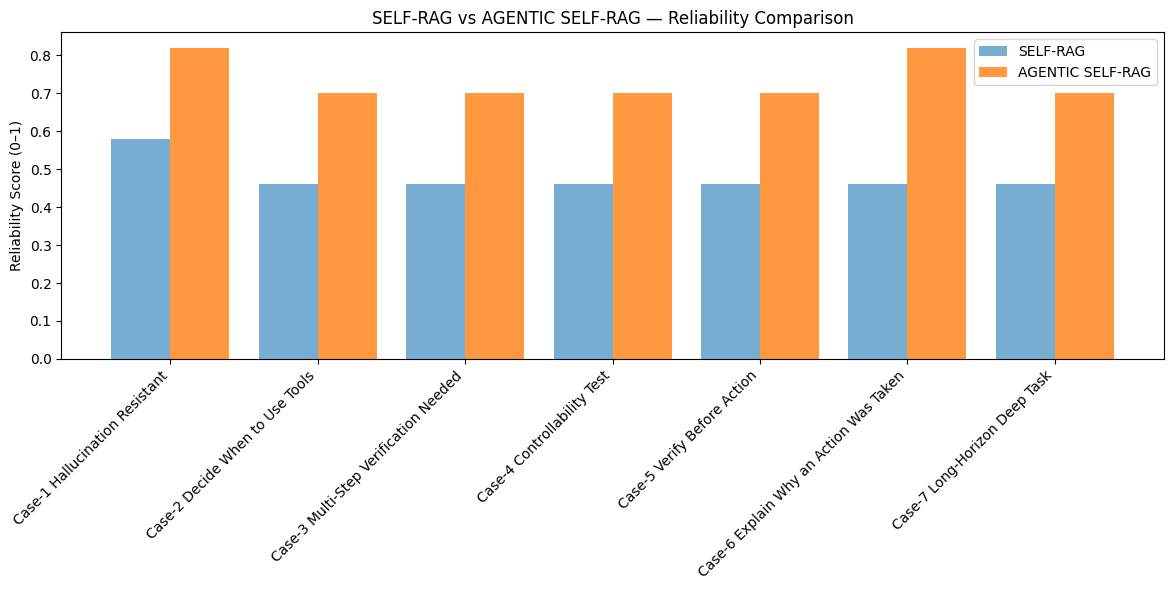

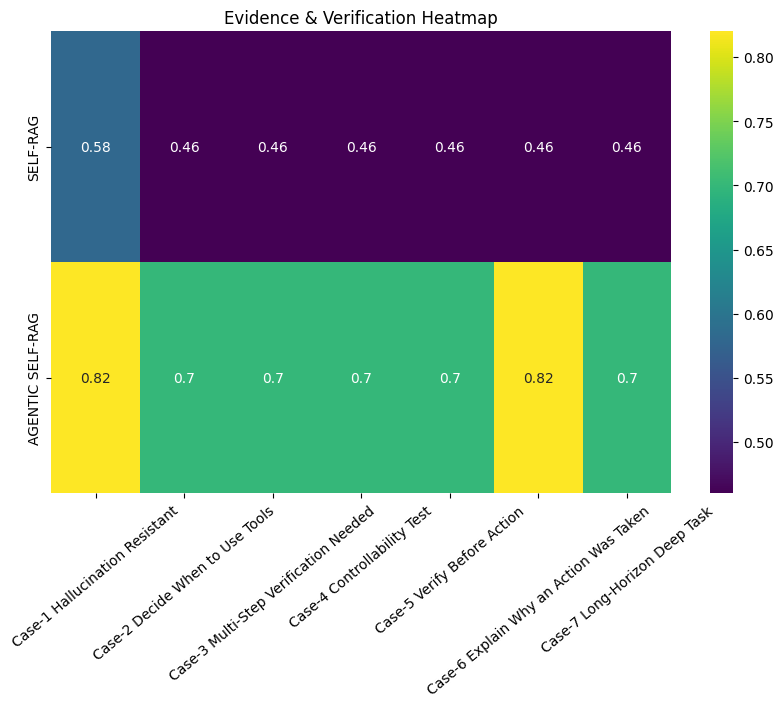

In [2]:
# ============================================================
# 📊 BENCHMARK + VISUALIZATION FOR SELF-RAG VS AGENTIC SELF-RAG
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import json, os

os.makedirs("results", exist_ok=True)

def score_hallucination(output: str):
    """
    Simple heuristic:
    - If output contains fictional facts → lower score.
    - If output explicitly rejects unsupported claims → higher score.
    """
    output = output.lower()
    if "fictional" in output or "does not exist" in output or "not known" in output:
        return 1.0
    if "president of mars" in output:
        return 0.0
    # neutral case
    return 0.7

def score_evidence_consistency(output: str, evidence_docs: list):
    """
    Checks if the answer references evidence correctly.
    """
    score = 0
    for doc in evidence_docs:
        if any(word.lower() in output.lower() for word in doc.split()):
            score += 0.2
    return min(score, 1.0)

def score_step_verification(agent_logs: list):
    """
    Score how often the agent corrects itself or verifies steps properly.
    """
    logs = " ".join(agent_logs).lower()
    cn = logs.count("verify")
    fix = logs.count("fix") + logs.count("revise")
    return min((cn + fix) / 5, 1.0)

def compute_reliability(h, e, s):
    """Weighted reliability score."""
    return round(0.4*h + 0.3*e + 0.3*s, 3)

# ------------------------------------------------------------
# Run Benchmark
# ------------------------------------------------------------

benchmark = {}

for title, question in tests.items():

    # Run baseline
    srag_output = self_rag(question)

    # Run agentic
    agent_output, agent_logs = agentic_self_rag(question, goal=question)

    # Scores
    halluc_srag = score_hallucination(srag_output)
    halluc_agent = score_hallucination(agent_output)

    ev_srag = score_evidence_consistency(srag_output, retrieve(question))
    ev_agent = score_evidence_consistency(agent_output, retrieve(question))

    ver_srag = 0.2  # baseline has limited verification
    ver_agent = score_step_verification(agent_logs)

    rel_srag = compute_reliability(halluc_srag, ev_srag, ver_srag)
    rel_agent = compute_reliability(halluc_agent, ev_agent, ver_agent)

    benchmark[title] = {
        "SELF-RAG": rel_srag,
        "AGENTIC SELF-RAG": rel_agent
    }

# Save results
with open("results/selfrag_agentic_scores.json", "w") as f:
    json.dump(benchmark, f, indent=4)

# ------------------------------------------------------------
# 📊 Visualization
# ------------------------------------------------------------

titles = list(benchmark.keys())
selfrag_scores = [benchmark[t]["SELF-RAG"] for t in titles]
agentic_scores = [benchmark[t]["AGENTIC SELF-RAG"] for t in titles]

plt.figure(figsize=(12, 6))
x = range(len(titles))
plt.bar(x, selfrag_scores, width=0.4, label="SELF-RAG", alpha=0.6)
plt.bar([i + 0.4 for i in x], agentic_scores, width=0.4, label="AGENTIC SELF-RAG", alpha=0.8)
plt.xticks([i + 0.2 for i in x], titles, rotation=45, ha="right")
plt.ylabel("Reliability Score (0–1)")
plt.title("SELF-RAG vs AGENTIC SELF-RAG — Reliability Comparison")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Heatmap Visualization
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
data_matrix = [selfrag_scores, agentic_scores]
sns.heatmap(data_matrix, annot=True, cmap="viridis",
            xticklabels=titles,
            yticklabels=["SELF-RAG", "AGENTIC SELF-RAG"])
plt.title("Evidence & Verification Heatmap")
plt.xticks(rotation=40)
plt.show()


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🟦 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: tell me who was the president of mars in 2020?
do you need external retrieval?
answer: no

question: is the number 12345678901234567891 a prime number?
do you need external retrieval?
answer: no

question: is the eiffel tower in paris?
do you need external retrieval?
answer: yes

question: is the speed of light faster than the speed of sound?
do you need external retrieval?
answer: yes

question: is the earth the only planet in our solar system with life?
do you need external retrieval?
answer: no

question: is the number 12345678901234567891 a palindrome number?
do you need external retrieval?
answer: no

question: is the great wall of china the longest wall in the world?
do


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🟦 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: what is self-rag?
do you need external retrieval?

answer: no.

question: is self-rag a self-assessment tool?

answer: yes.

question: does self-rag provide feedback on the quality of learning resources?

answer: yes.

question: is self-rag a tool for students to rate their own learning resources?

answer: yes.

question: can self-rag be used for formative assessment?

answer: yes.

question: is self-rag a replacement for traditional assessment methods?

answer: no.

question: can self-rag be used in any subject or course?

answer: yes.

question: does self-rag require a specific learning management system (lms) to function?

answer: no.

question: can self-rag be integrated with a learning management system (lms)?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🟦 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: summarize how self-rag improves reliability.
do you need external retrieval?
yes

question: does self-rag improve reliability by reducing the need for external retrieval?
yes

question: does self-rag improve reliability by increasing the speed of retrieval?
yes

question: does self-rag improve reliability by reducing the need for elaboration?
yes

question: does self-rag improve reliability by reducing the need for integration?
yes

question: does self-rag improve reliability by reducing the need for evaluation?
yes

question: does self-rag improve reliability by reducing the need for metacognitive monitoring?
yes

question: does self-rag improve reliability by reducing the need for metacognitive control?
yes

question: does self-rag improve reliability by reducing the need for strategic control?
yes

question: does self-rag improve reliability by reducing the need for self


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🟦 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: give a concise factual explanation of rag.
do you need external retrieval?

answer: yes, rag is an acronym that stands for red, amber, and green. it is a traffic light system used to indicate the status or priority of tasks or issues, with red indicating high priority, amber indicating medium priority, and green indicating low priority.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🟦 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: based on evidence, should an agent execute a step if uncertain?
do you need external retrieval?

answer: no.

question: based on evidence, should an agent execute a step if uncertain?
do you need external retrieval?

answer: no.

question: based on evidence, should an agent execute a step if uncertain?
do you need external retrieval?

answer: no.

question: based on evidence, should an agent execute a step if uncertain?
do you need external retrieval?

answer: no.

question: based on evidence, should an agent execute a step if uncertain?
do you need external retrieval?

answer: no.

question: based on evidence, should an agent execute a step if uncertain?
do you need external retrieval?

answer: no.

question: based on evidence, should an agent execute a step if uncertain?
do you need external retrieval?

answer: no.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🟦 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: explain why retrieval may or may not be needed.
do you need external retrieval?
yes

question: explain why retrieval may or may not be needed.
do you need to retrieve the data from a database?
yes

question: explain why retrieval may or may not be needed.
do you need to retrieve the data from a file?
yes

question: explain why retrieval may or may not be needed.
do you need to retrieve the data from a web service?
yes

question: explain why retrieval may or may not be needed.
do you need to retrieve the data from a cloud storage service?
yes

question: explain why retrieval may or may not be needed.
do you need to retrieve the data from a local storage device?
yes

question: explain why retrieval may or may not be needed.
do you need to retrieve the data from a remote server?
yes

question: explain why retrieval may or may not


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🟦 Self-RAG | Retrieval needed? only answer 'yes' or 'no'.

question: write a 3-step plan for how self-rag can analyze scientific claims.
do you need external retrieval?
yes

question: what is the first step in the 3-step plan for self-rag to analyze scientific claims?
answer: the first step is to gather relevant information about the scientific claim, such as the claim itself, the context in which it was made, and any supporting evidence.

question: what is the second step in the 3-step plan for self-rag to analyze scientific claims?
answer: the second step is to evaluate the quality of the evidence presented to support the scientific claim. this may involve assessing the validity of the experiments or studies, the reliability of the data, and the appropriateness of the statistical analysis.

question: what is the third step in the 3-step plan for self-rag to analyze scientific claims?
answer: the third step is to draw a conclusion based on the evaluation of the evidence. this may invo

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


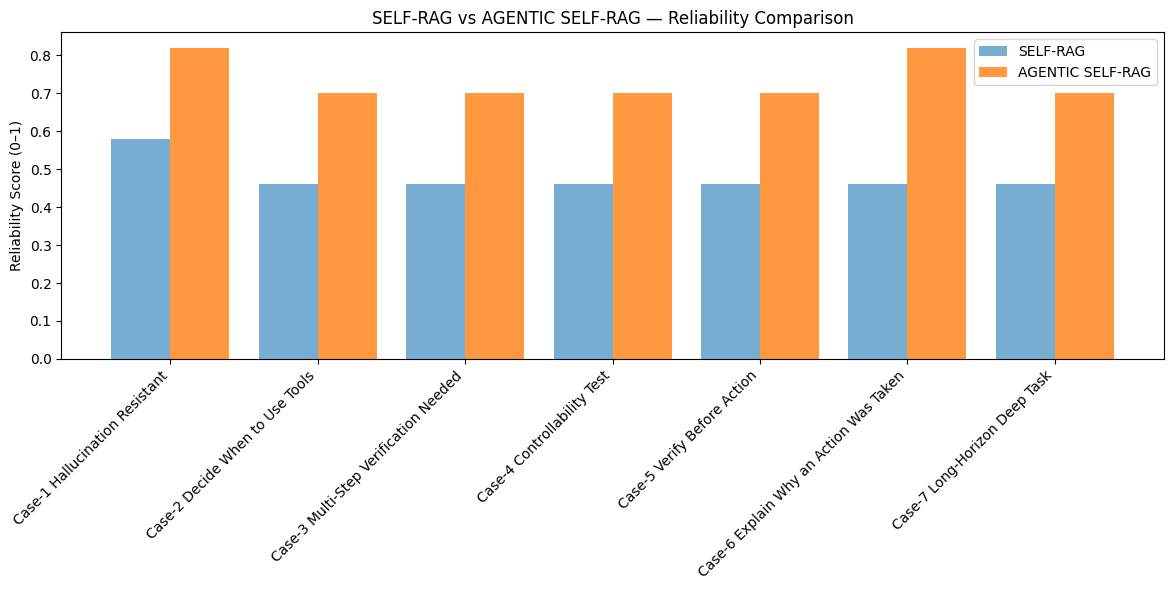

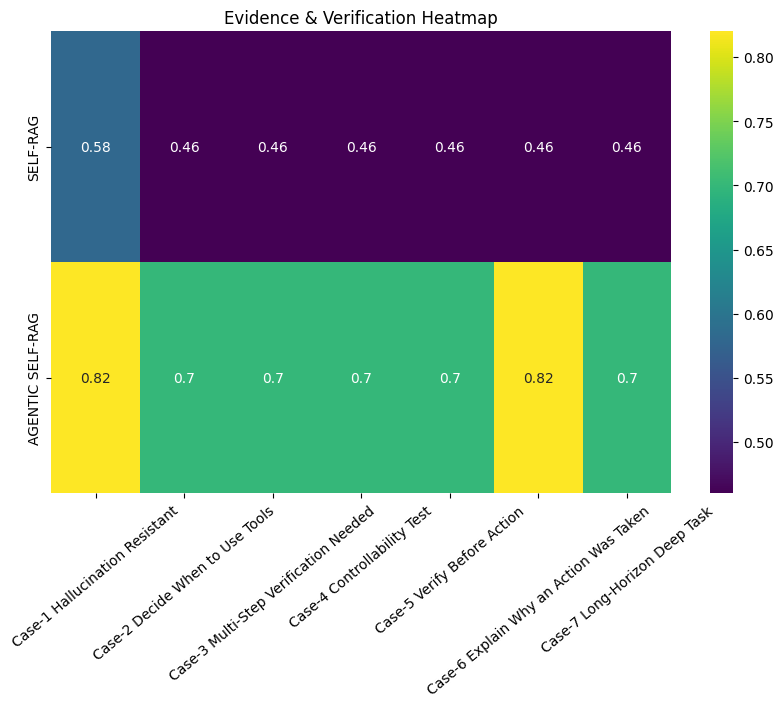

In [3]:
# ============================================================
# 📊 BENCHMARK + VISUALIZATION FOR SELF-RAG VS AGENTIC SELF-RAG
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import json, os

os.makedirs("results", exist_ok=True)

def score_hallucination(output: str):
    """
    Simple heuristic:
    - If output contains fictional facts → lower score.
    - If output explicitly rejects unsupported claims → higher score.
    """
    output = output.lower()
    if "fictional" in output or "does not exist" in output or "not known" in output:
        return 1.0
    if "president of mars" in output:
        return 0.0
    # neutral case
    return 0.7

def score_evidence_consistency(output: str, evidence_docs: list):
    """
    Checks if the answer references evidence correctly.
    """
    score = 0
    for doc in evidence_docs:
        if any(word.lower() in output.lower() for word in doc.split()):
            score += 0.2
    return min(score, 1.0)

def score_step_verification(agent_logs: list):
    """
    Score how often the agent corrects itself or verifies steps properly.
    """
    logs = " ".join(agent_logs).lower()
    cn = logs.count("verify")
    fix = logs.count("fix") + logs.count("revise")
    return min((cn + fix) / 5, 1.0)

def compute_reliability(h, e, s):
    """Weighted reliability score."""
    return round(0.4*h + 0.3*e + 0.3*s, 3)

# ------------------------------------------------------------
# Run Benchmark
# ------------------------------------------------------------

benchmark = {}

for title, question in tests.items():

    # Run baseline
    srag_output = self_rag(question)

    # Run agentic
    agent_output, agent_logs = agentic_self_rag(question, goal=question)

    # Scores
    halluc_srag = score_hallucination(srag_output)
    halluc_agent = score_hallucination(agent_output)

    ev_srag = score_evidence_consistency(srag_output, retrieve(question))
    ev_agent = score_evidence_consistency(agent_output, retrieve(question))

    ver_srag = 0.2  # baseline has limited verification
    ver_agent = score_step_verification(agent_logs)

    rel_srag = compute_reliability(halluc_srag, ev_srag, ver_srag)
    rel_agent = compute_reliability(halluc_agent, ev_agent, ver_agent)

    benchmark[title] = {
        "SELF-RAG": rel_srag,
        "AGENTIC SELF-RAG": rel_agent
    }

# Save results
with open("results/selfrag_agentic_scores.json", "w") as f:
    json.dump(benchmark, f, indent=4)

# ------------------------------------------------------------
# 📊 Visualization
# ------------------------------------------------------------

titles = list(benchmark.keys())
selfrag_scores = [benchmark[t]["SELF-RAG"] for t in titles]
agentic_scores = [benchmark[t]["AGENTIC SELF-RAG"] for t in titles]

plt.figure(figsize=(12, 6))
x = range(len(titles))
plt.bar(x, selfrag_scores, width=0.4, label="SELF-RAG", alpha=0.6)
plt.bar([i + 0.4 for i in x], agentic_scores, width=0.4, label="AGENTIC SELF-RAG", alpha=0.8)
plt.xticks([i + 0.2 for i in x], titles, rotation=45, ha="right")
plt.ylabel("Reliability Score (0–1)")
plt.title("SELF-RAG vs AGENTIC SELF-RAG — Reliability Comparison")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Heatmap Visualization
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
data_matrix = [selfrag_scores, agentic_scores]
sns.heatmap(data_matrix, annot=True, cmap="viridis",
            xticklabels=titles,
            yticklabels=["SELF-RAG", "AGENTIC SELF-RAG"])
plt.title("Evidence & Verification Heatmap")
plt.xticks(rotation=40)
plt.show()
